In [1]:
### importieren
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()  # for plot styling
import numpy as np
from sklearn.datasets.samples_generator import make_blobs #random data generator
import pandas as pd
import time

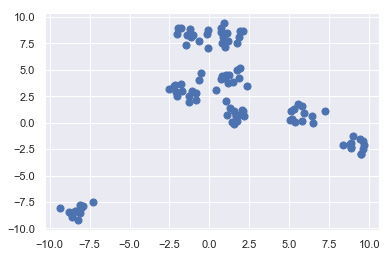

In [2]:
#generate data
X, y_true = make_blobs(n_samples=100, centers=8,
                       cluster_std=0.60, random_state=0, )
plt.scatter(X[:, 0], X[:, 1], s=50);

In [4]:
blubb = pd.DataFrame(X)

In [5]:
blubb.T

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,2.073709,1.674674,9.619210,5.044956,1.426136,1.303590,5.934505,-8.107482,1.086929,-8.033171,...,0.443599,1.895938,0.698261,-0.679905,9.499111,-2.225994,-0.843264,-2.071283,1.651791,9.676632
1,8.702098,0.680019,-2.456149,0.300948,0.045653,1.364158,0.958917,-8.537265,0.770019,-8.067083,...,3.115309,5.185403,8.543232,7.742454,-2.990810,3.458378,2.176987,2.949049,0.681932,-2.086693


In [6]:
df_rand = pd.DataFrame(np.random.randint(0,100,size=(2, 100)), index =("PC1","PC2"))

In [7]:
df_rand

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
PC1,86,65,36,94,82,97,42,66,15,43,...,16,90,76,25,47,47,6,91,79,82
PC2,30,25,53,83,29,67,83,27,74,51,...,55,9,73,86,33,40,45,33,63,6


### Attempt 2

In [8]:
import WWDK_Package.Cluster as cl
liste = []
lib = cl.Kmeans(inits=10, method="rng")
for i in range(10):
    start = time.time()
    lib.fit(X)
    end = time.time()
    liste.append(end-start)
    print(end-start)
np.sum(liste)

/Users/benedict/Desktop/Programmieren/Bioinfoprojekt/project-04-group-04/WWDK_Package/Cluster.py:70: RuntimeWarning: Mean of empty slice.
  self.cluster_centers_[i] = self._data[position].mean(axis = 0)
/anaconda3/envs/igem/lib/python3.6/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


0.5066299438476562
0.5076370239257812
0.5178298950195312
0.523291826248169
0.4948139190673828
0.5111751556396484
0.5215730667114258
0.49295783042907715
0.5344719886779785
0.5643830299377441


5.1747636795043945

In [8]:
clusters = np.expand_dims(lib.cluster_centers_, axis=1)
clusters.shape

(8, 1, 2)

In [5]:
def plot(data, dist, clusters,k):
    for i in range(k):
        graph = pd.DataFrame(data[np.argwhere(dist == i)].squeeze())
        center = pd.DataFrame(clusters[i]).T
        #print("Cluster"+ str(i) +  " -- Assigned Points \n" + str(graph))
        plt.plot(graph[0], graph[1], "o")
        plt.plot(center[0],center[1], "kx")
    plt.show

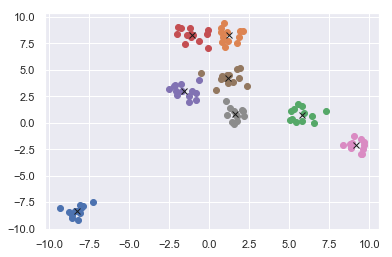

In [10]:
plot(X, lib.labels_, lib.cluster_centers_,8)

## Numba Acceleration (hopefully)

In [15]:
import random
import math
from statistics import mean
from sklearn.datasets.samples_generator import make_blobs
import matplotlib.pyplot as plt
import urllib.request as url
import numpy as np
import scanpy as sc
import pandas as pd
import tarfile
import csv
import numba
from sklearn.base import BaseEstimator, ClusterMixin, TransformerMixin


class Kmeans(BaseEstimator, ClusterMixin, TransformerMixin):   # Input: processed dataset, Output: clustered data (kmeans, kmeans++)
    def __init__(self, inits=10, k=8, maxit=300, method="++"):
        
        self.labels_ = None
        self.cluster_centers_ = None
        self._inits = inits
        self._k = k
        self._maxit = maxit
        self._method = method
       # dot = np.random.choice(range(len(self._data)), self._k, replace=False)
        #self._clusters = self._data[dot]
   
    def fit(self,data):
        self._data = data
        output = self.complicated(self._data, self._k, self._inits, self._maxit, self._method)
        self.cluster_centers_ = output[0]
        self.labels_ = output[1]
        
        return self
    
    @staticmethod
    @numba.jit(nopython=True) 
    def complicated(data, k, inits, maxit, method):
        
        #best_clust = float('inf')
        best_clust = 10000
        
        for i in (range(inits)):
            
            if method == "rng": # random centers are choosen
                #print("rng")
                dot = np.random.choice(len(data), k, replace=False)
                cluster_centers_ = data[dot]
                
                '''elif method == "++": # kmeans++ is initiated
                    #print("++")
                    dot2 = np.random.choice(len(data), replace=False) # random startpunkt
                    clusters = np.array([data[dot2]])
                    pointer = np.array([])
                    for i in range (k-1):
                        D = np.array([])

                        for j in range (len(data)):
                            D = np.append(D,np.min(np.sum((data[j]-clusters)**2, axis = 1)))

                        pointer = np.append(pointer, D, axis = 0) 

                        p = D/np.sum(D)
                        cummulative_p = np.cumsum(p)

                        r = random.random()
                        ind = np.where(cummulative_p >= r)[0][0]

                        clusters = np.append(clusters,[data[ind]], axis = 0)
                    cluster_centers_ = clusters'''
            
            else:
                raise AttributeError("No valid method")
            
            for i in range(maxit):
                
                eucl = np.zeros((k,len(data)))
                for i in range(k):
                    for j in range(len(data)):
                        eucl[(i-1,j-1)] = np.linalg.norm(cluster_centers_[i-1]-data[j-1]) # euclidean dist by using integrated numpy function
                labels_ = np.zeros(len(data))
                for i in range(len(data)):
                    labels_[i] = np.argmin(eucl[:,i])
                for i in range(k): # range of clusters
                    position = np.where(labels_ == i) # position im array bestimmen und dann die entspechenden punkte aus data auslesen
                    #cluster_centers_ = np.zeros((k,1,2))
                    x_pos = np.mean(data[position[0], 0])
                    y_pos = data[position[0], 1].mean()
                    cluster_centers_[i] = np.array((x_pos,y_pos))
                    #out = pd.DataFrame(data[np.argwhere(dist == i)].squeeze())
                overall_quality = 0
                for i in range(len(data)):
                    min_val = np.min(eucl.T[i])
                    overall_quality = overall_quality + min_val
                if overall_quality < best_clust:
                    best_clust = overall_quality
                    best_dist = labels_
                    best_centers = cluster_centers_
            cluster_centers_ = best_centers
            labels_ = best_dist
                
        return cluster_centers_, labels_
   
    
    def predict(self, X):
        clusters = np.expand_dims(self.cluster_centers_, axis=1)
        data = np.expand_dims(X, axis=0)
        eucl = np.linalg.norm(clusters-data, axis=2) # euclidean dist by using integrated numpy function
        self.labels_ = np.argmin(eucl, axis = 0)
        return self.labels_ #returns the cluster with minimum distance
    
    def transform(self, X):
        clusters = np.expand_dims(self.cluster_centers_, axis=1)
        data = np.expand_dims(X, axis=0)
        eucl = np.linalg.norm(clusters-data, axis=2)
        return eucl.T

In [7]:
X_kmeans = Kmeans(method="rng")
X_kmeans.fit(X)

Kmeans(inits=None, k=None, maxit=None, method=None)

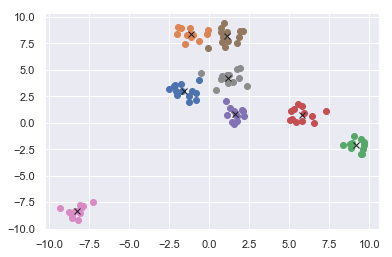

In [8]:
plot(X, X_kmeans.labels_, X_kmeans.cluster_centers_,8)


In [14]:
liste = []
X_kmeans = Kmeans(inits=10,method="rng")
for i in range(10):
    start = time.time()
    X_kmeans.fit(X)
    end = time.time()
    liste.append(end-start)
    print(end-start)
np.sum(liste)

1.518367052078247
1.5065698623657227
1.5087900161743164
1.5146517753601074
1.5078201293945312
1.510308027267456
1.520320177078247
1.5097401142120361
1.5153169631958008
1.503438949584961


15.115323066711426

In [14]:
best_clust = float('inf')

In [15]:
eucl = np.zeros((8,100))

In [16]:
clusters = np.expand_dims(lib.cluster_centers_, axis=1)
ex_data = np.expand_dims(X, axis=0)
eucl = np.zeros((8,100))
for i in range(8):
    for j in range(len(X)):
        eucl[(i-1,j-1)] = np.linalg.norm(lib.cluster_centers_[i-1]-X[j-1])
      


In [17]:
clusters = np.expand_dims(lib.cluster_centers_, axis=1)
ex_data = np.expand_dims(X, axis=0)
eucl = np.linalg.norm(clusters-ex_data, axis=2)

In [18]:
labels_ = np.zeros(100)
for i in range(100):
    labels_[i] = np.argmin(eucl[:,i])

In [19]:
position = np.where(labels_ == 0)

In [20]:
cluster_centers = np.zeros((8,1,2))
x = X[position, 0].mean()
y = X[position, 1].mean()
cluster_centers[0] = np.array((x,y))

In [21]:
cluster_centers

array([[[-8.30683493, -8.31236453]],

       [[ 0.        ,  0.        ]],

       [[ 0.        ,  0.        ]],

       [[ 0.        ,  0.        ]],

       [[ 0.        ,  0.        ]],

       [[ 0.        ,  0.        ]],

       [[ 0.        ,  0.        ]],

       [[ 0.        ,  0.        ]]])

In [28]:
overall_quality = np.sum(np.min(eucl.T, axis=1))
overall_quality

70.38401459879539

In [24]:
np.min(eucl.T, axis=1)

array([0.95199605, 0.12622525, 0.53191334, 0.85845568, 0.77248717,
       0.65222373, 0.25514666, 0.30053618, 0.53309165, 0.36749785,
       0.44175115, 0.20515424, 0.81933969, 0.55925028, 0.59231995,
       0.30549065, 1.12098414, 0.48252805, 1.40367254, 0.97944395,
       0.89910183, 0.97160292, 0.42631033, 0.99447347, 0.31694692,
       0.92647464, 0.96185785, 0.50184976, 0.67778971, 0.3557621 ,
       0.61793862, 0.82002594, 0.69046286, 0.94341246, 0.10456339,
       0.5548292 , 0.58864061, 0.64408669, 0.76710878, 0.31386202,
       0.56092549, 0.58120494, 0.78302274, 0.71050549, 1.1214883 ,
       0.14786822, 0.95641113, 0.49660638, 0.48158043, 0.92200634,
       0.0632922 , 1.04502258, 0.86439377, 0.17029686, 1.41780806,
       0.81464096, 0.65355788, 0.9331102 , 0.14433487, 1.07001784,
       0.97051316, 0.70579429, 0.39946304, 0.65490934, 0.43916233,
       1.22519634, 0.73738496, 0.35124664, 1.41899004, 0.36878306,
       0.06345   , 0.5882784 , 0.82942334, 0.63610208, 0.81049

In [31]:
overall_quality = 0
for i in range(len(X)):
    min_val = np.min(eucl.T[i])
    overall_quality = overall_quality + min_val
overall_quality

70.3840145987954

In [12]:
import random
import math
from statistics import mean
from sklearn.datasets.samples_generator import make_blobs
import matplotlib.pyplot as plt
import urllib.request as url
import numpy as np
import scanpy as sc
import pandas as pd
import tarfile
import csv
import numba
from sklearn.base import BaseEstimator, ClusterMixin, TransformerMixin


class Kmeans_numba(BaseEstimator, ClusterMixin, TransformerMixin):   # Input: processed dataset, Output: clustered data (kmeans, kmeans++)
    def __init__(self, inits=10, k=8, maxit=300, method="++"):
        
        self.labels_ = None
        self.cluster_centers_ = None
        self._inits = inits
        self._k = k
        self._maxit = maxit
        self._method = method
       # dot = np.random.choice(range(len(self._data)), self._k, replace=False)
        #self._clusters = self._data[dot]
   
    def fit(self,data):
        self._data = data
        output = self.complicated(self._data, self._k, self._inits, self._maxit, self._method)
        self.cluster_centers_ = output[0]
        self.labels_ = output[1]
        
        return self
    
    @staticmethod
    @numba.jit(nopython=True) 
    def complicated(data, k, inits, maxit, method):
        
        #best_clust = float('inf')
        best_clust = 100000
        
        for i in (range(inits)):
            
            if method == "rng": # random centers are choosen
                #print("rng")
                dot = np.random.choice(len(data), k, replace=False)
                cluster_centers_ = data[dot]
            else:
                raise AttributeError("No valid method")
            
            for i in range(maxit):
                
                labels_ = np.ones(len(data))
                eucl = np.ones((k,len(data)))
                overall_quality = 0
                for i in range(k):
                    for j in range(len(data)):
                        eucl[(i,j)] = np.linalg.norm(cluster_centers_[i]-data[j]) # euclidean dist by using integrated numpy function
                        labels_[j] = np.argmin(eucl[:,j])
                    
                 
                position = np.where(labels_ == i) # position im array bestimmen und dann die entspechenden punkte aus data auslesen
                #cluster_centers_ = np.zeros((k,1,2))
                x_pos = np.mean(data[position[0], 0])
                y_pos = data[position[0], 1].mean()
                cluster_centers_[i] = np.array((x_pos,y_pos))
                    #out = pd.DataFrame(data[np.argwhere(dist == i)].squeeze())
                    
               
                for i in range(len(data)):
                    min_val = np.min(eucl.T[i])
                    overall_quality = overall_quality + min_val
                    
                if overall_quality < best_clust:
                    best_clust = overall_quality
                    best_dist = labels_
                    best_centers = cluster_centers_
            cluster_centers_ = best_centers
            labels_ = best_dist
                
        return cluster_centers_, labels_
   
    
    def predict(self, X):
        clusters = np.expand_dims(self.cluster_centers_, axis=1)
        data = np.expand_dims(X, axis=0)
        eucl = np.linalg.norm(clusters-data, axis=2) # euclidean dist by using integrated numpy function
        self.labels_ = np.argmin(eucl, axis = 0)
        return self.labels_ #returns the cluster with minimum distance
    
    def transform(self, X):
        clusters = np.expand_dims(self.cluster_centers_, axis=1)
        data = np.expand_dims(X, axis=0)
        eucl = np.linalg.norm(clusters-data, axis=2)
        return eucl.T

## Numba versuch -.-

In [13]:
liste = []
X_kmeans = Kmeans_numba(inits=10,method="rng")
for i in range(10):
    start = time.time()
    X_kmeans.fit(X)
    end = time.time()
    liste.append(end-start)
    print(end-start)
np.sum(liste)

4.18881893157959
1.522660732269287
1.5290520191192627
1.557873010635376
1.5222258567810059
1.5310018062591553
1.527271032333374
1.5255579948425293
1.5321359634399414
1.5141160488128662


17.950713396072388

In [14]:
%%timeit
X_kmeans.fit(X)

1.5 s ± 2.12 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


## Internet version vs our version
from http://www.goldsborough.me/c++/python/cuda/2017/09/10/20-32-46-exploring_k-means_in_python,_c++_and_cuda/

In [10]:
#@numba.jit(nopython=True) 
def k_means(data, k, number_of_iterations):
    n = len(data)
    number_of_features = data.shape[1]
    # Pick random indices for the initial centroids.
    initial_indices = np.random.choice(range(n), k)
    # We keep the centroids as |features| x k matrix.
    means = data[initial_indices].T
    # To avoid loops, we repeat the data k times depthwise and compute the
    # distance from each point to each centroid in one step in a
    # n x |features| x k tensor.
    repeated_data = np.stack([data] * k, axis=-1)
    all_rows = np.arange(n)
    zero = np.zeros([1, 1, 2])
    for _ in range(number_of_iterations):
        # Broadcast means across the repeated data matrix, gives us a
        # n x k matrix of distances.
        distances = np.sum(np.square(repeated_data - means), axis=1)
        # Find the index of the smallest distance (closest cluster) for each
        # point.
        assignment = np.argmin(distances, axis=-1)
        # Again to avoid a loop, we'll create a sparse matrix with k slots for
        # each point and fill exactly the one slot that the point was assigned
        # to. Then we reduce across all points to give us the sum of points for
        # each cluster.
        sparse = np.zeros([n, k, number_of_features])
        sparse[all_rows, assignment] = data
        # To compute the correct mean, we need to know how many points are
        # assigned to each cluster (without a loop).
        counts = (sparse != zero).sum(axis=0)
        # Compute new assignments.
        means = sparse.sum(axis=0).T / counts.clip(min=1).T
    return means.T

## rand python implementation

In [59]:
liste = []

for i in range(100):
    start = time.time()
    k_means(X,8,300)
    end = time.time()
    liste.append(end-start)
    #print(end-start)
print( "Time:"+ str(np.sum(liste)))
print( "Mean Time:"+ str(np.mean(liste)))

Time:1.794316053390503
Mean Time:0.01794316053390503


## our code

In [64]:
import WWDK_Package.Cluster as cl
liste = []
lib = cl.Kmeans(inits=1, method="rng")
for i in range(100):
    start = time.time()
    lib.fit(X)
    end = time.time()
    liste.append(end-start)
    #print(end-start)
print( "Time:"+ str(np.sum(liste)))
print( "Mean Time:"+ str(np.mean(liste)))

/Users/benedict/Desktop/Programmieren/Bioinfoprojekt/project-04-group-04/WWDK_Package/Cluster.py:70: RuntimeWarning: Mean of empty slice.
  self.cluster_centers_[i] = self._data[position].mean(axis = 0)
/anaconda3/envs/igem/lib/python3.6/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


Time:4.9951136112213135
Mean Time:0.049951136112213135


## sklearn

In [63]:
import sklearn.cluster as sk
sk_kmeans = sk.KMeans(init="random",n_init=1)
liste = []
for i in range(100):
    start = time.time()
    sk_kmeans.fit(X)
    end = time.time()
    liste.append(end-start)
    #print(end-start)
print( "Time:"+ str(np.sum(liste)))
print( "Mean Time:"+ str(np.mean(liste)))

Time:0.12574529647827148
Mean Time:0.001257452964782715


## Optimization

In [ ]:
for i in range(self._k): # range of clusters
    position = np.where(self.labels_ == i) # position im array bestimmen und dann die entspechenden punkte aus data auslesen
    self.cluster_centers_[i] = self._data[position].mean(axis = 0)

In [71]:
lib.labels_

array([7, 2, 0, 1, 2, 2, 1, 5, 2, 5, 4, 2, 7, 2, 5, 7, 7, 5, 2, 7, 0, 7,
       0, 1, 7, 7, 4, 5, 1, 0, 2, 3, 3, 6, 5, 2, 6, 7, 1, 4, 3, 5, 1, 5,
       1, 3, 3, 4, 3, 5, 7, 3, 7, 4, 4, 7, 1, 2, 7, 5, 7, 4, 0, 7, 4, 7,
       1, 2, 3, 0, 5, 1, 7, 3, 0, 7, 4, 7, 1, 5, 7, 1, 7, 4, 2, 7, 3, 7,
       4, 6, 4, 4, 7, 7, 0, 3, 3, 3, 2, 0])

TypeError: unhashable type: 'numpy.ndarray'

In [74]:
lib._data

array([[ 2.0737091 ,  8.70209833],
       [ 1.67467427,  0.68001896],
       [ 9.6192097 , -2.45614888],
       [ 5.04495632,  0.30094763],
       [ 1.42613574,  0.0456529 ],
       [ 1.30359031,  1.36415787],
       [ 5.93450486,  0.95891726],
       [-8.10748206, -8.53726546],
       [ 1.08692881,  0.77001949],
       [-8.03317149, -8.06708308],
       [ 1.1641107 ,  3.79132988],
       [ 1.74947621,  0.63481908],
       [ 0.76076201,  7.58507011],
       [ 2.16172321,  0.6565951 ],
       [-7.91948308, -7.86425577],
       [ 1.08757172,  8.52242026],
       [-1.95212982,  9.00163273],
       [-8.59387451, -8.70023255],
       [ 1.03150541,  2.0681289 ],
       [-1.49642716,  7.38698713],
       [ 9.51085924, -2.98700653],
       [-0.1277204 ,  8.37908681],
       [ 8.85651449, -2.42095035],
       [ 5.53568129,  1.73561763],
       [-1.4090578 ,  8.31693385],
       [-2.01054677,  8.41709804],
       [ 1.71444449,  5.02521524],
       [-8.80078794, -8.40104151],
       [ 5.28680743,

In [14]:
import random
import math
import matplotlib.pyplot as plt
import numpy as np
import scanpy as sc
import pandas as pd
import numba
from numba import njit, jit
from statistics import mean
from sklearn.datasets.samples_generator import make_blobs
from sklearn.base import BaseEstimator, ClusterMixin, TransformerMixin

class MiniBatchKMeans(BaseEstimator, ClusterMixin, TransformerMixin):
    """Performs mini-batch k-means on a set of input data."""
    def __init__(self, k=8, inits=300, max_iterations=300, tol=1e-3, batch_size=128):
        """Simple mini-batch k-means clustering implementation in pure Python.
        
        Args:
            k (int): number of clusters to fit.
            inits (int): number of independent initializations to perform.
            max_iterations (int): maximum number of iterations to perform.
            tol (float): tolerance for early stopping.
            batch_size (int): number of datapoints for the minibatch.
        """
        self.labels_ = None
        self.cluster_centers_ = None
        self._k = k
        self._inits = inits
        self._max_iterations = max_iterations
        self._tol = tol
        self._batch_size = batch_size
        
    def create_batch(self, data): 
        data_batch = np.random.choice(range(len(data)), self._batch_size, replace=False)
        return data[data_batch]
        
        """chooses x (x = batch_size) random points from the data to create the data batch
        """
        
    def initialize(self, data): 
        indices = np.random.choice(range(len(data)), self._k, replace=False)
        return data[indices], np.zeros(self._k)
        
        """chooses k random data points from data, to set centers for clustering
        """
    
    def expectation(self, data, centroids): 
        centroids = np.expand_dims(centroids, axis=1)
        data = np.expand_dims(data, axis=0)
        metric = np.linalg.norm(centroids - data, axis=2)
        return np.argmin(metric, axis=0)
        
        """measures the euclidean distance between each data_batch points and center points using numpys linalg.norm function
        """
    
    @staticmethod
    @numba.jit(nopython=True)
    def _maximization_aux(data, assignments, centroids, centroid_count): #verschiebt die centroids richtung clustermittelpunkt mit lr
        update = centroids.copy()
        for idx, assignment in enumerate(assignments):
            data_point = data[idx]
            centroid_count[assignment] += 1
            lr = 1 / centroid_count[assignment] #learning rate
            update[assignment] = update[assignment] * (1 - lr) + data_point * lr
        return update
    
        """Moves the centroids to the new centroid point of the assigned data_batch points. But not completely, but according to the learning rate
        """
    
    def maximization(self, data, assignments, centroids, centroid_count): 
        return MiniBatchKMeans._maximization_aux(data, assignments, centroids, centroid_count)
    
        """This part applies maximization_aux on the data using maximization_aux
        """
    
    def final_assignments(self, data, centroids): 
        assignments = []
        for idx in range(len(data) // self._batch_size + 1):
            start = idx * self._batch_size
            stop = min(idx * self._batch_size + self._batch_size, len(data))
            sub_result = self.expectation(data[start:stop], centroids)
            assignments.append(sub_result)
        return np.concatenate(assignments, axis=0)
    
        """Assignes the rest of the data points to the centroids, which were determined before (not only batch_points)
        """
    
    def fit(self, data): #alles zusammen
        centroids, counts = self.initialize(data)
        
        old_centroids = None
        for idx in range(self._max_iterations):
            old_centroids = centroids.copy()
            
            batch = self.create_batch(data)
            assignments = self.expectation(batch, centroids)
            centroids = self.maximization(batch, assignments, centroids, counts)
            
            if np.linalg.norm(centroids - old_centroids) < self._tol:
                break

        self.labels_ = self.final_assignments(data, centroids)
        self.cluster_centers_ = centroids
                
        return self
    
    def predict(self, data):
        
        centroids = np.expand_dims(self.cluster_centers_, axis=1)
        data = np.expand_dims(data, axis=0)
        metric = np.linalg.norm(centroids - data, axis=2)
        self.labels_ = np.argmin(metric, axis=0)
        
        return self.labels_

    
    def transform(self, data):
        
        centroids = np.expand_dims(self.cluster_centers_, axis=1)
        data = np.expand_dims(data, axis=0)
        metric = np.linalg.norm(centroids - data, axis=2)
        
        return metric.T


In [15]:
test = MiniBatchKMeans(batch_size=20)

In [16]:
test.fit(X)

MiniBatchKMeans(batch_size=None, inits=None, k=None, max_iterations=None,
        tol=None)

In [18]:
test.fit_transform(X)

array([[ 2.155247  , 20.29129702, 19.38852443, 10.77488929,  3.45983932,
         6.33698767,  1.08804225, 20.35797536],
       [ 6.05781328, 13.98060025, 12.88395966,  5.8362973 ,  8.2586646 ,
         2.40559998,  7.93245957, 13.79502405],
       [12.4374    , 19.58141166, 18.37788324,  2.87536645, 15.4166025 ,
        10.6475214 , 14.01033852, 19.07019698],
       [ 7.47076745, 16.51471152, 15.3540569 ,  2.50783592, 10.29777153,
         5.31722153,  9.22053822, 16.1983198 ],
       [ 6.67848478, 13.38841704, 12.2797869 ,  5.96677757,  8.76911439,
         2.83243541,  8.54843329, 13.18264487],
       [ 5.35752286, 14.15225206, 13.08505807,  6.38422014,  7.486498  ,
         1.63689335,  7.22562031, 14.01353299],
       [ 7.44208168, 17.61667184, 16.45775259,  2.17435902, 10.39602933,
         5.91089479,  9.085925  , 17.30382916],
       [17.88597842,  1.02276004,  0.65613233, 17.33057249, 18.18894766,
        13.95606366, 19.38839585,  0.35475517],
       [ 5.95267666, 13.59288308

In [1]:
from WWDK_Package import Cluster

In [2]:
km = Cluster.Kmeans()
mb = Cluster.MiniBatchKMeans(batch_size= 10)

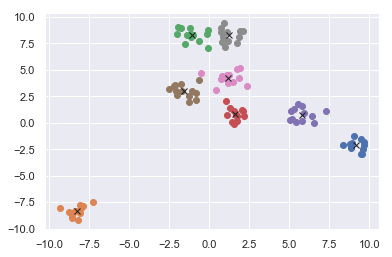

In [8]:
km.fit_predict(X)
plot(X, km.labels_, km.cluster_centers_,8)

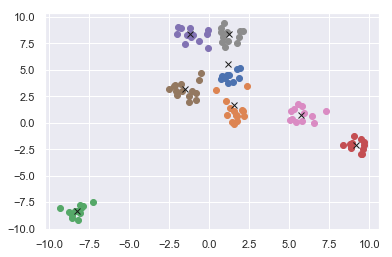

In [7]:
mb.fit_predict(X)
plot(X, mb.labels_, mb.cluster_centers_,8)

## Our code vs another python code

In [81]:
liste = []
lib = Cluster.Kmeans(inits=1, method="rng")
for i in range(100):
    start = time.time()
    lib.fit(X)
    end = time.time()
    liste.append(end-start)
   # print(end-start)
print( "Time:"+ str(np.sum(liste)))
print( "Mean Time:"+ str(np.mean(liste)))

Time:0.11432385444641113
Mean Time:0.0011432385444641114


In [87]:
liste = []
lib = Cluster.Kmeans(inits=1, method="rng")
for i in range(10000):
    start = time.time()
    lib.fit(X)
    end = time.time()
    liste.append(end-start)
   # print(end-start)
print( "Time:"+ str(np.sum(liste)))
print( "Mean Time:"+ str(np.mean(liste)))

Time:23.789578914642334
Mean Time:0.0023789578914642333


Rand python implementation

In [86]:
liste = []

for i in range(10000):
    start = time.time()
    k_means(X,8,300)
    end = time.time()
    liste.append(end-start)
    #print(end-start)
print( "Time:"+ str(np.sum(liste)))
print( "Mean Time:"+ str(np.mean(liste)))

Time:187.65190386772156
Mean Time:0.018765190386772157


sklearn

In [88]:
import sklearn.cluster as sk
sk_kmeans = sk.KMeans(init="random",n_init=10)
liste = []
for i in range(10000):
    start = time.time()
    sk_kmeans.fit(X)
    end = time.time()
    liste.append(end-start)
    #print(end-start)
print( "Time:"+ str(np.sum(liste)))
print( "Mean Time:"+ str(np.mean(liste)))

Time:11.836426973342896
Mean Time:0.0011836426973342896


In [97]:
%%timeit
import sklearn.cluster as sk
from WWDK_Package import Cluster
sk_kmeans = sk.KMeans(init="random",n_init=10)
sk_kmeans.fit(X)

9.88 ms ± 92 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [95]:
%%timeit
k_means(X,8,300)

17.2 ms ± 87.2 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [102]:
%%timeit

lib = Cluster.Kmeans(inits=10, method="rng")
lib.fit(X)

365 ms ± 35.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [7]:
from WWDK_Package import Cluster as cl
from WWDK_Package import Utilities as u
from WWDK_Package import Data as d

bla = cl.Kmeans()

In [5]:
bla.fit_transform(X)

array([[ 3.19596126, 12.97369769, 19.93107225,  7.92158327,  4.55972383,
         6.7759816 ,  0.95199605,  8.75084469],
       [ 8.08873307,  8.02539909, 13.43478644,  0.12622525,  3.58885883,
         3.98366879,  7.58694875,  4.09151057],
       [15.1672224 ,  0.53191334, 18.8583758 ,  8.63457386, 10.77746368,
        12.44505715, 13.60247172,  5.02476249],
       [10.06758235,  4.810574  , 15.88897341,  3.46069339,  5.52137027,
         7.14149489,  8.81924202,  0.85845568],
       [ 8.61149419,  8.06318847, 12.82915327,  0.77248717,  4.19529813,
         4.20130794,  8.21074371,  4.39881831],
       [ 7.3197931 ,  8.62888215, 13.63801155,  0.65222373,  2.87205904,
         3.30243402,  6.8903377 ,  4.50130084],
       [10.14902355,  4.49717645, 16.9933053 ,  4.31817154,  5.78197823,
         7.7754224 ,  8.67859104,  0.25514666],
       [18.22107541, 18.43460971,  0.30053618, 13.47880817, 15.78390864,
        13.25139618, 19.21480789, 16.7045017 ],
       [ 7.8203754 ,  8.60801942

/Users/benedict/Desktop/Programmieren/Bioinfoprojekt/project-04-group-04/WWDK_Package/Cluster.py:80: RuntimeWarning: Mean of empty slice.
  if np.any(np.isnan(self._data[position].mean(axis=0)) == True):
/Users/benedict/Desktop/Programmieren/Bioinfoprojekt/project-04-group-04/WWDK_Package/Cluster.py:80: RuntimeWarning: Mean of empty slice.
  if np.any(np.isnan(self._data[position].mean(axis=0)) == True):
/Users/benedict/Desktop/Programmieren/Bioinfoprojekt/project-04-group-04/WWDK_Package/Cluster.py:80: RuntimeWarning: Mean of empty slice.
  if np.any(np.isnan(self._data[position].mean(axis=0)) == True):
/Users/benedict/Desktop/Programmieren/Bioinfoprojekt/project-04-group-04/WWDK_Package/Cluster.py:80: RuntimeWarning: Mean of empty slice.
  if np.any(np.isnan(self._data[position].mean(axis=0)) == True):


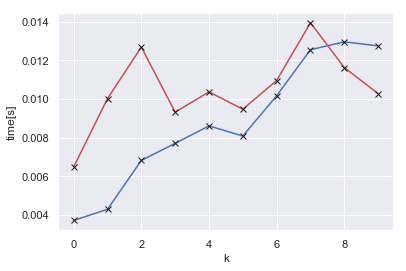

In [6]:
np.seterr(all="ignore")
u.time_k_plot(X,10,5)

In [8]:
from WWDK_Package import Cluster as cl
from WWDK_Package import Utilities as u
from WWDK_Package import Data as d
pbmc = d.Loader("http://cf.10xgenomics.com/samples/cell-exp/1.1.0/pbmc3k/pbmc3k_filtered_gene_bc_matrices.tar.gz")

In [10]:
test_pbmc = pbmc.process()[0]

/Users/benedict/Desktop/Programmieren/Bioinfoprojekt/project-04-group-04/WWDK_Package/Cluster.py:80: RuntimeWarning: Mean of empty slice.
  if np.any(np.isnan(self._data[position].mean(axis=0)) == True):


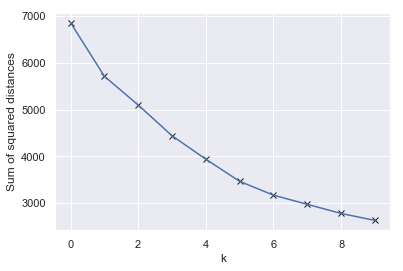

In [11]:
u.elbow_plot(test_pbmc, 10)